# Dataset Analysis: BTC, FI-2010, Battery

This notebook analyzes the **preprocessed** datasets used in this repo:
- BTC
- FI-2010
- Battery Markets

It focuses on:
1. Data shapes and split sizes
2. Class distribution (`up`, `stat`, `down`)
3. Cross-dataset comparison
4. LOB visualization for intuition

In [15]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure imports from project root work when notebook is under /notebooks
PROJECT_ROOT = Path.cwd().resolve().parent if Path.cwd().name == 'notebooks' else Path.cwd().resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import constants as cst
from preprocessing.fi_2010 import fi_2010_load
from constants import SamplingType

DATA_ROOT = PROJECT_ROOT / 'data'

# ----------------------
# Analysis configuration
# ----------------------
HORIZON = 10
ALL_HORIZONS = [10, 20, 50, 100]

# Same battery defaults used in run_experiments.py
BATTERY_START_DATE = '2021-01-01'
BATTERY_END_DATE = '2021-01-11'

# Optional: trigger preprocessing from raw battery files for selected dates
REBUILD_BATTERY_PREPROCESSED = False

# FI-2010 loader params (used only for analysis here)
FI_SEQ_SIZE = 10
FI_ALL_FEATURES = False

CLASS_ID_TO_NAME = {0: 'up', 1: 'stat', 2: 'down'}
CLASS_ORDER = [0, 1, 2]

print(f'Project root: {PROJECT_ROOT}')
print(f'Using horizon: {HORIZON}')

Project root: /home/ordenter/ASL/TLOB
Using horizon: 10


In [16]:
def horizon_to_label_offset(horizon: int) -> int:
    mapping = {10: 4, 20: 3, 50: 2, 100: 1}
    if horizon not in mapping:
        raise ValueError(f'Unsupported horizon {horizon}. Expected one of {list(mapping)}')
    return mapping[horizon]

def extract_orderbook_levels(orderbook_row: np.ndarray):
    """
    Expects orderbook row layout: [sell1, vsell1, buy1, vbuy1, sell2, vsell2, ...]
    Returns ask_prices, ask_sizes, bid_prices, bid_sizes
    """
    asks_p = orderbook_row[0::4]
    asks_q = orderbook_row[1::4]
    bids_p = orderbook_row[2::4]
    bids_q = orderbook_row[3::4]
    return asks_p, asks_q, bids_p, bids_q

def class_distribution(labels: np.ndarray) -> pd.DataFrame:
    labels = labels.astype(np.int64)
    total = len(labels)
    rows = []
    for class_id in CLASS_ORDER:
        count = int((labels == class_id).sum())
        rows.append({
            'class_id': class_id,
            'class_name': CLASS_ID_TO_NAME[class_id],
            'count': count,
            'pct': (count / total * 100.0) if total else np.nan,
        })
    return pd.DataFrame(rows)

def _slice_and_clean_labels(full_array: np.ndarray, horizon: int) -> np.ndarray:
    offset = horizon_to_label_offset(horizon)
    labels = full_array[:, -offset]
    labels = labels[np.isfinite(labels)].astype(np.int64)
    return labels

def load_btc_split(split: str, horizon: int):
    arr = np.load(DATA_ROOT / 'BTC' / f'{split}.npy')
    x_orderbook = arr[:, : cst.N_LOB_LEVELS * cst.LEN_LEVEL]
    y = _slice_and_clean_labels(arr, horizon)
    return x_orderbook, y

def load_battery_split(split: str, horizon: int):
    arr = np.load(DATA_ROOT / 'battery_markets' / f'{split}.npy')
    start = cst.LEN_ORDER
    end = cst.LEN_ORDER + cst.N_LOB_LEVELS * cst.LEN_LEVEL
    x_orderbook = arr[:, start:end]
    y = _slice_and_clean_labels(arr, horizon)
    return x_orderbook, y

def load_fi_splits(horizon: int):
    x_tr, y_tr, x_va, y_va, x_te, y_te = fi_2010_load(
        str(DATA_ROOT / 'FI_2010'),
        seq_size=FI_SEQ_SIZE,
        horizon=horizon,
        all_features=FI_ALL_FEATURES,
    )
    return (
        x_tr.numpy(), y_tr.numpy().astype(np.int64),
        x_va.numpy(), y_va.numpy().astype(np.int64),
        x_te.numpy(), y_te.numpy().astype(np.int64),
    )

In [17]:
# Optional battery preprocessing rebuild (from raw files) for selected dates.
# Keeps this notebook centered on preprocessed data while allowing date-range control here too.
if REBUILD_BATTERY_PREPROCESSED:
    from preprocessing.battery import BatteryDataBuilder

    builder = BatteryDataBuilder(
        data_dir=str(DATA_ROOT),
        date_trading_days=[BATTERY_START_DATE, BATTERY_END_DATE],
        split_rates=cst.SPLIT_RATES,
        sampling_type=SamplingType.NONE,
        sampling_time='1s',
        sampling_quantity=0,
    )
    builder.prepare_save_datasets()
    print('Battery preprocessing rebuilt for requested date range.')
else:
    print('Skipping battery rebuild. Using existing preprocessed data at data/battery_markets/*.npy')

Skipping battery rebuild. Using existing preprocessed data at data/battery_markets/*.npy


In [18]:
datasets = {
    'btc': {},
    'battery': {},
    'fi_2010': {},
}

for split in ['train', 'val', 'test']:
    x_btc, y_btc = load_btc_split(split, HORIZON)
    datasets['btc'][split] = {'x': x_btc, 'y': y_btc}

    x_bat, y_bat = load_battery_split(split, HORIZON)
    datasets['battery'][split] = {'x': x_bat, 'y': y_bat}

x_tr, y_tr, x_va, y_va, x_te, y_te = load_fi_splits(HORIZON)
datasets['fi_2010']['train'] = {'x': x_tr, 'y': y_tr}
datasets['fi_2010']['val'] = {'x': x_va, 'y': y_va}
datasets['fi_2010']['test'] = {'x': x_te, 'y': y_te}

shape_rows = []
for dataset_name, splits in datasets.items():
    for split_name, split_data in splits.items():
        shape_rows.append({
            'dataset': dataset_name,
            'split': split_name,
            'n_samples_features': int(split_data['x'].shape[0]),
            'n_features': int(split_data['x'].shape[1]),
            'n_samples_labels': int(split_data['y'].shape[0]),
        })

shape_df = pd.DataFrame(shape_rows).sort_values(['dataset']).reset_index(drop=True)
shape_df

,dataset,split,n_samples_features,n_features,n_samples_labels
0,battery,train,4256742,40,4256723
1,battery,val,520567,40,520548
2,battery,test,1216698,40,1216679
3,btc,train,2780963,40,2780944
4,btc,val,344454,40,344435
5,btc,test,605453,40,605434
6,fi_2010,train,203800,40,203791
7,fi_2010,val,50950,40,50941
8,fi_2010,test,139587,40,139578


## Class Distribution per Dataset and Split

Class IDs follow repository labeling logic:
- `0` = `up`
- `1` = `stat`
- `2` = `down`

In [19]:
dist_rows = []
for dataset_name, splits in datasets.items():
    for split_name, split_data in splits.items():
        dist_df = class_distribution(split_data['y'])
        dist_df['dataset'] = dataset_name
        dist_df['split'] = split_name
        dist_rows.append(dist_df)

dist_all = pd.concat(dist_rows, axis=0, ignore_index=True)
dist_all = dist_all[['dataset', 'split', 'class_id', 'class_name', 'count', 'pct']]

dist_all.sort_values(['dataset', 'split', 'class_id']).reset_index(drop=True)

,dataset,split,class_id,class_name,count,pct
0,battery,test,0,up,178181,14.644865
1,battery,test,1,stat,861995,70.848186
2,battery,test,2,down,176503,14.506949
3,battery,train,0,up,623884,14.656439
4,battery,train,1,stat,3022246,70.999358
5,battery,train,2,down,610593,14.344203
6,battery,val,0,up,79953,15.359390
7,battery,val,1,stat,364869,70.093248
8,battery,val,2,down,75726,14.547362
9,btc,test,0,up,138122,22.813717


,dataset,class_name,count,pct
0,battery,up,882018,14.715138
1,battery,stat,4249110,70.889981
2,battery,down,862822,14.394882
3,btc,up,866584,23.227752
4,btc,stat,1992627,53.409994
5,btc,down,871602,23.362254
6,fi_2010,up,71420,18.112652
7,fi_2010,stat,252834,64.120616
8,fi_2010,down,70056,17.766732


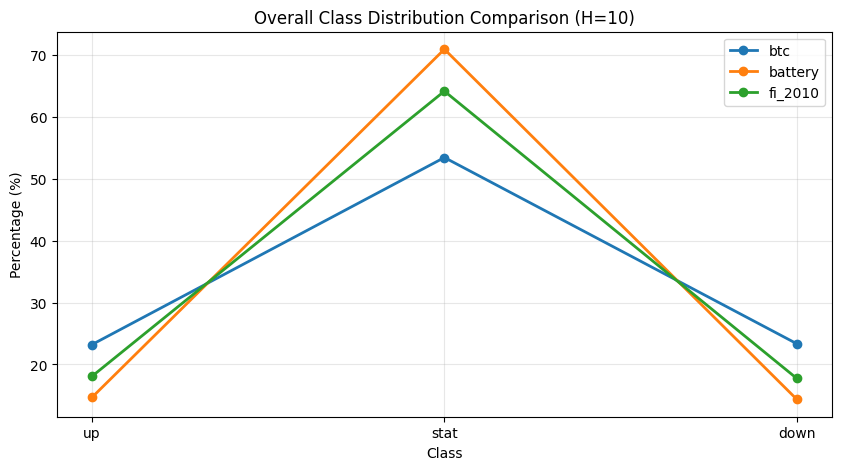

In [20]:
# Compare overall class distribution (train+val+test) across datasets
overall_rows = []
for dataset_name, splits in datasets.items():
    y_all = np.concatenate([splits['train']['y'], splits['val']['y'], splits['test']['y']])
    df = class_distribution(y_all)
    df['dataset'] = dataset_name
    overall_rows.append(df)

overall_dist = pd.concat(overall_rows, ignore_index=True)
overall_table = overall_dist[['dataset', 'class_id', 'class_name', 'count', 'pct']].sort_values(['dataset', 'class_id']).reset_index(drop=True)
display(overall_table[['dataset', 'class_name', 'count', 'pct']])

fig, ax = plt.subplots(figsize=(10, 5))
for dataset_name in overall_dist['dataset'].unique():
    df = overall_dist[overall_dist['dataset'] == dataset_name].sort_values('class_id')
    ax.plot(df['class_name'], df['pct'], marker='o', linewidth=2, label=dataset_name)

ax.set_title(f'Overall Class Distribution Comparison (H={HORIZON})')
ax.set_xlabel('Class')
ax.set_ylabel('Percentage (%)')
ax.grid(alpha=0.3)
ax.legend()
plt.show()

,dataset,horizon,class_name,count,pct
0,battery,10,up,882018,14.715138
1,battery,10,stat,4249110,70.889981
2,battery,10,down,862822,14.394882
3,battery,20,up,964605,16.093058
4,battery,20,stat,4093933,68.301429
5,battery,20,down,935382,15.605514
6,battery,50,up,1114810,18.599293
7,battery,50,stat,3816369,63.671626
8,battery,50,down,1062651,17.729081
9,battery,100,up,1235048,20.605838


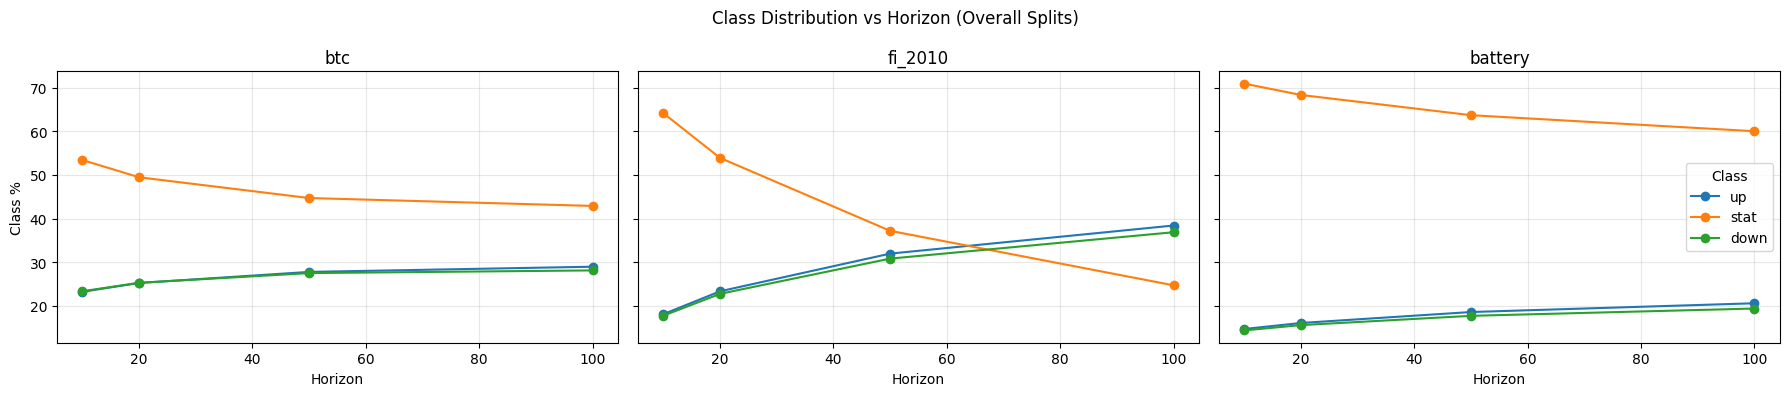

In [21]:
# Compare class distribution across horizons for each dataset (overall splits)
horizon_rows = []
for h in ALL_HORIZONS:
    # BTC
    y_btc = []
    y_battery = []
    for split in ['train', 'val', 'test']:
        _, y = load_btc_split(split, h)
        y_btc.append(y)
        _, yb = load_battery_split(split, h)
        y_battery.append(yb)

    y_btc = np.concatenate(y_btc)
    y_battery = np.concatenate(y_battery)

    x_tr, y_tr, x_va, y_va, x_te, y_te = load_fi_splits(h)
    y_fi = np.concatenate([y_tr, y_va, y_te])

    for dataset_name, y_all in [('btc', y_btc), ('battery', y_battery), ('fi_2010', y_fi)]:
        tmp = class_distribution(y_all)
        tmp['dataset'] = dataset_name
        tmp['horizon'] = h
        horizon_rows.append(tmp)

horizon_dist = pd.concat(horizon_rows, ignore_index=True)
horizon_table = horizon_dist[['dataset', 'horizon', 'class_id', 'class_name', 'count', 'pct']].sort_values(['dataset', 'horizon', 'class_id']).reset_index(drop=True)
display(horizon_table[['dataset', 'horizon', 'class_name', 'count', 'pct']])

fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=True)
for ax, dataset_name in zip(axes, ['btc', 'fi_2010', 'battery']):
    sub = horizon_dist[horizon_dist['dataset'] == dataset_name]
    for class_name in ['up', 'stat', 'down']:
        line = sub[sub['class_name'] == class_name].sort_values('horizon')
        ax.plot(line['horizon'], line['pct'], marker='o', label=class_name)
    ax.set_title(dataset_name)
    ax.set_xlabel('Horizon')
    ax.grid(alpha=0.3)

axes[0].set_ylabel('Class %')
axes[-1].legend(title='Class')
plt.suptitle('Class Distribution vs Horizon (Overall Splits)')
plt.tight_layout()
plt.show()

## LOB Visualization

The next cells visualize one LOB snapshot per dataset and a short temporal view of best bid/ask.

Note: this uses **preprocessed** values (z-scored), so absolute price/volume scales are normalized.

In [28]:
# Print one preprocessed LOB row per dataset for direct inspection
print_lob_rows = []
for dataset_name in ['btc', 'fi_2010', 'battery']:
    row = datasets[dataset_name]['train']['x'][0]
    lob_cols = {}
    for lvl in range(1, cst.N_LOB_LEVELS + 1):
        base = (lvl - 1) * 4
        lob_cols[f'sell{lvl}'] = float(row[base])
        lob_cols[f'vsell{lvl}'] = float(row[base + 1])
        lob_cols[f'buy{lvl}'] = float(row[base + 2])
        lob_cols[f'vbuy{lvl}'] = float(row[base + 3])
    print_lob_rows.append(pd.Series(lob_cols, name=dataset_name))

lob_preview = pd.DataFrame(print_lob_rows)
pd.set_option('display.max_columns', None)
display(lob_preview)

,sell1,vsell1,buy1,vbuy1,sell2,vsell2,buy2,vbuy2,sell3,vsell3,buy3,vbuy3,sell4,vsell4,buy4,vbuy4,sell5,vsell5,buy5,vbuy5,sell6,vsell6,buy6,vbuy6,sell7,vsell7,buy7,vbuy7,sell8,vsell8,buy8,vbuy8,sell9,vsell9,buy9,vbuy9,sell10,vsell10,buy10,vbuy10
btc,-1.457271,0.465049,-1.457335,2.146586,-1.457208,0.038556,-1.457398,-0.246619,-1.457145,-0.119687,-1.457462,0.248629,-1.457081,-0.261957,-1.457589,-0.231387,-1.457018,-0.126985,-1.457652,0.075049,-1.456954,0.221127,-1.457716,-0.229483,-1.456891,-0.323413,-1.457779,-0.153324,-1.456827,0.382331,-1.457842,-0.324788,-1.456764,-0.124129,-1.457906,-0.232868,-1.456700,-0.056221,-1.457969,-0.023641
fi_2010,0.331740,-0.568749,0.327150,-0.530692,0.333370,-0.737428,0.326524,-0.428326,0.333044,-0.845486,0.325864,-0.556442,0.332766,-0.752906,0.325152,-0.598897,0.332479,-0.942002,0.325454,-0.857820,0.333057,-0.472094,0.322879,-0.774269,0.333453,-0.673914,0.322460,-0.716783,0.332656,-0.334083,0.322242,-0.609562,0.333636,-0.468258,0.321212,-0.544051,0.335385,-0.421626,0.314274,-0.497146
battery,32.810927,1.271138,-0.222337,0.023020,36.939397,1.271138,-13.813260,2.831286,-0.822341,-0.289010,-0.822341,-0.289010,-0.822341,-0.289010,-0.822341,-0.289010,-0.822341,-0.289010,-0.822341,-0.289010,-0.822341,-0.289010,-0.822341,-0.289010,-0.822341,-0.289010,-0.822341,-0.289010,-0.822341,-0.289010,-0.822341,-0.289010,-0.822341,-0.289010,-0.822341,-0.289010,-0.822341,-0.289010,-0.822341,-0.289010


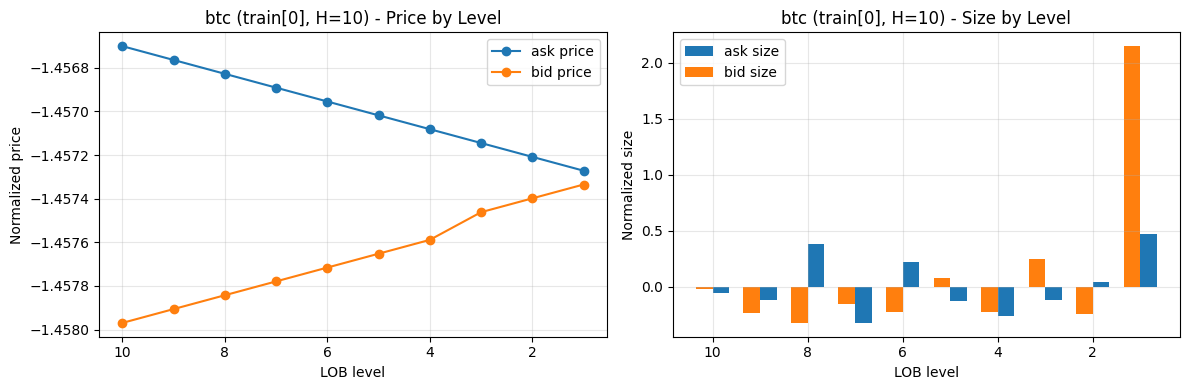

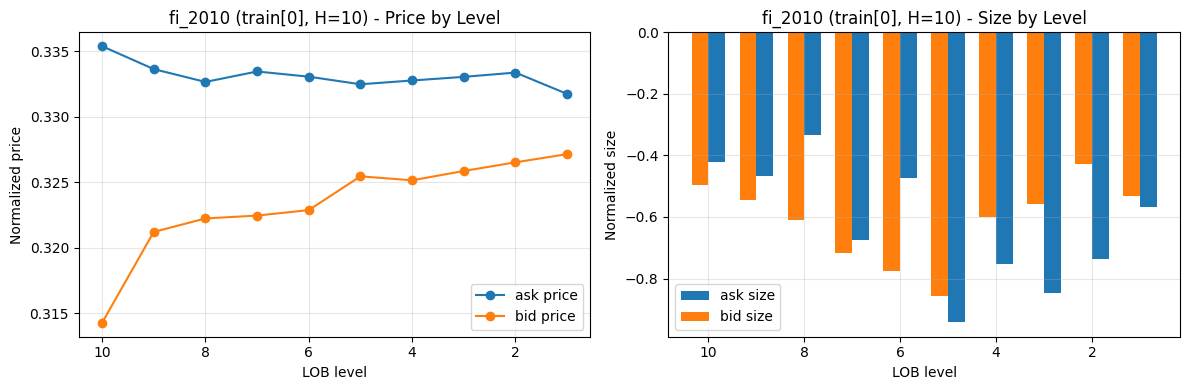

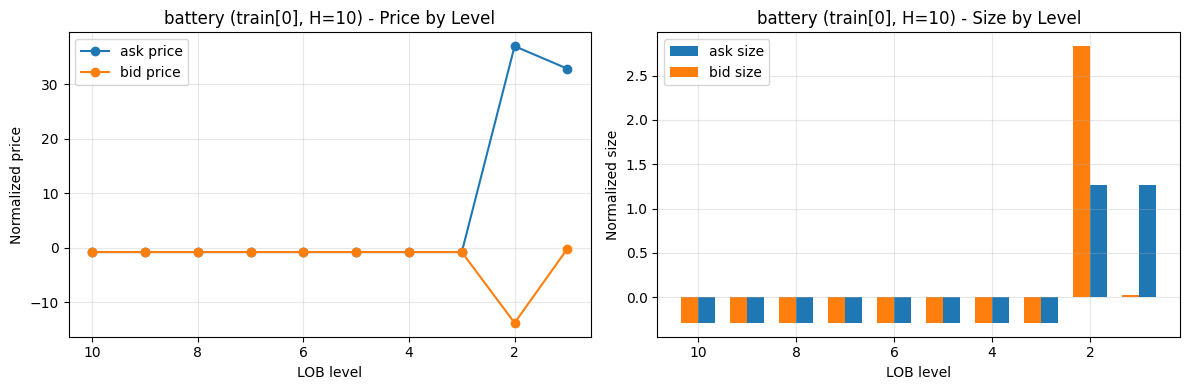

In [26]:
def plot_lob_snapshot(orderbook_row: np.ndarray, title: str):
    asks_p, asks_q, bids_p, bids_q = extract_orderbook_levels(orderbook_row)
    levels = np.arange(1, len(asks_p) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(levels, asks_p, marker='o', label='ask price')
    axes[0].plot(levels, bids_p, marker='o', label='bid price')
    axes[0].set_title(f'{title} - Price by Level')
    axes[0].set_xlabel('LOB level')
    axes[0].set_ylabel('Normalized price')
    axes[0].invert_xaxis()
    axes[0].grid(alpha=0.3)
    axes[0].legend()

    width = 0.35
    axes[1].bar(levels - width/2, asks_q, width=width, label='ask size')
    axes[1].bar(levels + width/2, bids_q, width=width, label='bid size')
    axes[1].set_title(f'{title} - Size by Level')
    axes[1].set_xlabel('LOB level')
    axes[1].set_ylabel('Normalized size')
    axes[1].invert_xaxis()
    axes[1].grid(alpha=0.3)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

for dataset_name in ['btc', 'fi_2010', 'battery']:
    row = datasets[dataset_name]['train']['x'][0]
    plot_lob_snapshot(row, f'{dataset_name} (train[0], H={HORIZON})')

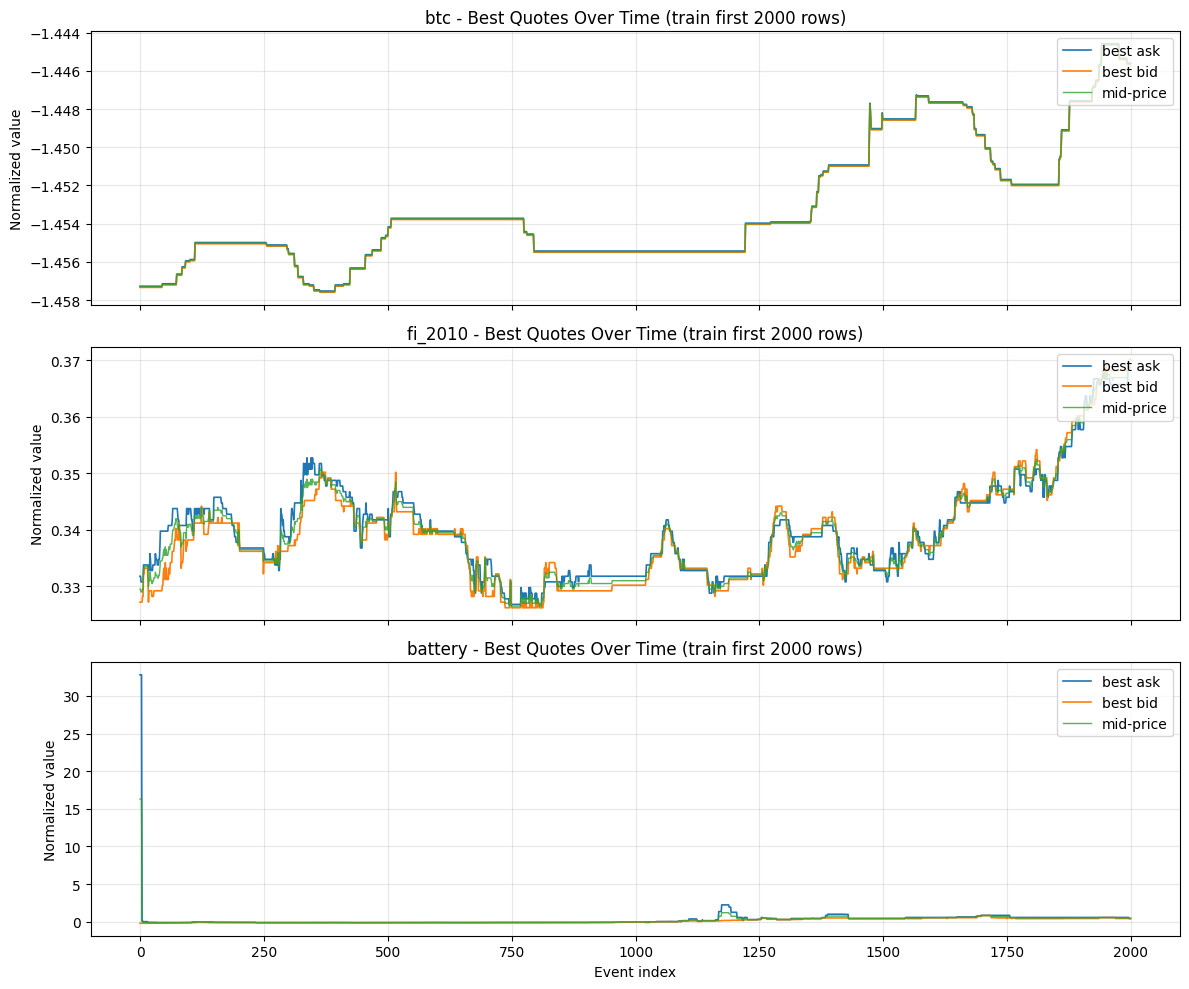

In [24]:
def best_quotes_over_time(orderbook_matrix: np.ndarray, n_points: int = 2000):
    n = min(n_points, orderbook_matrix.shape[0])
    x = orderbook_matrix[:n]
    best_ask = x[:, 0]
    best_bid = x[:, 2]
    spread = best_ask - best_bid
    mid = (best_ask + best_bid) / 2.0
    return best_ask, best_bid, spread, mid

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
for i, dataset_name in enumerate(['btc', 'fi_2010', 'battery']):
    orderbook = datasets[dataset_name]['train']['x']
    best_ask, best_bid, spread, mid = best_quotes_over_time(orderbook, n_points=2000)

    axes[i].plot(best_ask, label='best ask', linewidth=1.2)
    axes[i].plot(best_bid, label='best bid', linewidth=1.2)
    axes[i].plot(mid, label='mid-price', linewidth=1.0, alpha=0.8)
    axes[i].set_title(f'{dataset_name} - Best Quotes Over Time (train first 2000 rows)')
    axes[i].set_ylabel('Normalized value')
    axes[i].grid(alpha=0.3)
    axes[i].legend(loc='upper right')

axes[-1].set_xlabel('Event index')
plt.tight_layout()
plt.show()

In [25]:
# Compact summary stats for fast comparison
summary_rows = []
for dataset_name in ['btc', 'fi_2010', 'battery']:
    x = datasets[dataset_name]['train']['x']
    best_ask = x[:, 0]
    best_bid = x[:, 2]
    spread = best_ask - best_bid
    mid = (best_ask + best_bid) / 2.0

    summary_rows.append({
        'dataset': dataset_name,
        'train_rows': int(x.shape[0]),
        'features': int(x.shape[1]),
        'mid_mean': float(np.mean(mid)),
        'mid_std': float(np.std(mid)),
        'spread_mean': float(np.mean(spread)),
        'spread_std': float(np.std(spread)),
    })

pd.DataFrame(summary_rows).sort_values('dataset').reset_index(drop=True)

,dataset,train_rows,features,mid_mean,mid_std,spread_mean,spread_std
0,battery,4256742,40,-0.022720,0.217031,0.011430,0.077589
1,btc,2780963,40,-0.000002,1.000000,0.000068,0.000180
2,fi_2010,203800,40,-0.298087,0.897227,-0.000026,0.001839
